# Agent 실습
- Tool을 사용해 Agent를 단계별로 구성 해봅니다
- Dataframe을 사용한 Agent
- File을 활용하는 Agent

### 0.환경설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agents-rework")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agents-rework


### 1.사용자 Tool 생성

In [10]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 구글 뉴스 검색 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 파이썬 코드 생성 및 실행 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        # 파이썬 코드를 생성하고 실행하고 결과까지 확인
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result




### 2. 사용자 Tool을 검증(동작)

In [11]:
# 도구 이름과 설명을 출력
# 구글 검색 도구 정보
print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")

# 파이썬 코드 생성 도구 정보
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

# search_news("구글 재미나이")
python_repl_tool("print(1+1)")

C:\Users\yujap\AppData\Local\Temp\ipykernel_11436\2312710385.py:11: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  python_repl_tool("print(1+1)")
Python REPL can execute arbitrary code. Use with caution.


도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


'2\n'

### 3. 사용자 Tool을 리스트에 저장

In [12]:
# 도구를 리스트에 저장
tools = [search_news, python_repl_tool]

### 4. Agent를 위한 프롬프트를 생성
("placeholder", "{agent_scratchpad}")가 없으면 일반 멀티턴 채팅과 같은 코드가 된다  
일반 멀티턴 채팅과 다른부분은 agent_scratchpad가 중간중간 내용을 적고 저장할 공간을 만들어 주는 것이다

In [13]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        ( # 시스템 프롬프트
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"), # 멀티턴일때 사용
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"), # agent가 동작하면서 중간중간 메모를 남김
    ]
)

### 5. Agent 생성

In [14]:
## 3. Agent 생성
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# LLM 정의하기
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 생성하기
agent = create_tool_calling_agent(llm, tools, prompt)

In [17]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
# Agnent를 AgentExecutor를 이용해야만 실행하고 컨트롤이 가능함
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,

    # Agent의 동작을 자세히 출력
    # Agent가 실행 될때마다 실행 기록을 남겨둠. 메시지를 보려면 True
    verbose=True, 

    # Agent가 수행할 최대 반복 횟수
    max_iterations=10,
    # Agent가 수행할 최대 시간(초)
    max_execution_time=10,
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke({"input": "구글 재미나이의 최근 뉴스"})

print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': '구글 재미나이'}`


[{'url': 'https://news.google.com/rss/articles/CBMikAFBVV95cUxPNnZEV1RqZjlaWldleTdtbTRiS0FleUZzdUZ1c0MxUDBLejlzRGRiN0JONkN4TnhMM1I0ZUt3NktQTmRINmNSZFRGalJWdHBnZ1daYlpXdXI5dE1DU3NXbHluaEl3MTVNWXl3cVpXT05XWktXQUhFZ3dHRHVWOXMyUjhhQ25ldUtZb0JnWG5WTXg?oc=5', 'content': '새 학기, AI로 레벨업! 대학(원)생 대상 AI 프로 플랜 1년 무료 제공 - The Keyword'}, {'url': 'https://news.google.com/rss/articles/CBMiTEFVX3lxTE5vQ1BmRXVrR0psYWVRN0VDRGx6WlB3cEZfcXJSLVU4akpHa0FwR0ppRnVocWxta3FkeU9ic0ZiNWRsRWpZc1RCc2NkNWU?oc=5', 'content': '구글 AI 재미나이가 시키는대로 퍼포먼스 마케팅 해보니 - 브런치스토리'}, {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE5lUFlYeWFhVmM3cFZqX3JGMlZpR0IzZDhUbDdtY3d1ZmZTN0hOSnYwRlltY0ZFTXlJX21MXzRtM0tDX0lxdzJzNGN4UFVlTVZLMENabXZTWV9kVTJpM2RlUDhzR19yNVpKX3c?oc=5', 'content': "구글, '제미나이 2.5 프로' API 요금 공개…첨단 추론 모델은 가격 상승 추세 - AI타임스"}, {'url': 'https://news.google.com/rss/articles/CBMibEFVX3lxTFBucXkyQi1OazZRWVJndEV2dFd4RTZsTm

### Stream으로 진행내용을 출력

In [18]:
# AgentStreamParser 단계를 확인하면서 출력 가능함
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()



> Entering new None chain...
[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\nplt.show()"}`




Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplo

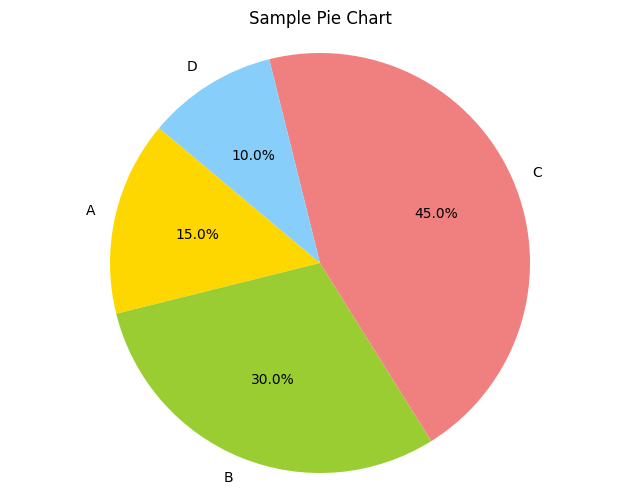

[관찰 내용]
Observation: 
파이 차트가 성공적으로 그려졌습니다. 차트는 각 섹션의 비율을 보여주며, 레이블과 색상이 포함되어 있습니다. 추가적인 질문이나 다른 요청이 있으시면 말씀해 주세요!

> Finished chain.
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트는 각 섹션의 비율을 보여주며, 레이블과 색상이 포함되어 있습니다. 추가적인 질문이나 다른 요청이 있으시면 말씀해 주세요!


In [19]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

### Callback을 수정해서 사용

In [15]:
# AgentCallbacks와 AgentStreamParser를 langchain_teddynote.messages에서 가져옵니다.
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print( f"Observation: {observation.get('observation')[0]}")  # 관찰 내용을 출력합니다.
    # for key,val in observation.item():
    #     print(f"Observation: {observation.get(key)}")
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [16]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "AI 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': 'AI 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMigwFBVV95cUxQVXQzb1lMdlA0M1haT2dCR1FRLS1OWWw1QlFpZ00wOUdaTzBKblZkMWtJM2sxalhOS1ZWR2o5SU9VaTN0R0l3bmpYZE4ycklacWktVm5TVGlDZ0d3TXZFS1RRMFZvOWh3djJoSTVQNFpWNF9PZEROcUl5c2pQNVd5OGFYNA?oc=5', 'content': "VC업계, 피지컬 AI·로봇 선점 경쟁...정책 리스크에 뜨는 '자동화' - 인베스트조선"}, {'url': 'https://news.google.com/rss/articles/CBMiYEFVX3lxTE5vUFFSQS1uWEowWVZKUWJmSGd3Rm1mendLeWU0blJtdFVMRDVER1JnTHBKc2MzZ1F5eUtaLVROSldDRXVwa0g5UFpzcE9tZkhlQlhGT3ZOVEc2UGJCdWgxXw?oc=5', 'content': '"8월 국내 벤처투자 1조원 돌파"…AI 쏠림 강화 - 아시아경제'}, {'url': 'https://news.google.com/rss/articles/CBMic0FVX3lxTE1TU0NCaDdMeW5Vampvc211MDRVM1VLaVRrc253YmZGU0lrekFPWVRxbnVaMl92Q3Q3bjZCSjYtcHJjUnkxVDhDNWYyNnc4ekgzNmZjZm9oQ2djMUtHeVd0aVRsRzZpSy1KbkZ3SjE4alFuc1E?oc=5', 'content': "빅테크 AI 인프라 '천문학적 투자' 경제효과 불투명, 고용 창출 기여도 낮아 - 비즈니스포스트"}, {'url': 'https://news.google.com

### 이전 대화내용 기억하는 Agent


In [20]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# session_id 를 저장할 딕셔너리 생성
store = {}


# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # session_id 가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 채팅 메시지 기록이 추가된 에이전트를 생성합니다.
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # 대화 session_id
    get_session_history,
    # 프롬프트의 질문이 입력되는 key: "input"
    input_messages_key="input",
    # 프롬프트의 메시지가 입력되는 key: "chat_history"
    history_messages_key="chat_history",
)

In [19]:
# 앞에 검색했던 기사 내용을 기억한다
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "구글 재미나이 최근 뉴스를 확인해줘"},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}}, # abc123 채팅창에 대한 아이디
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': '재미나이'}`


[{'url': 'https://news.google.com/rss/articles/CBMibEFVX3lxTFBucXkyQi1OazZRWVJndEV2dFd4RTZsTmd4MWNuOVRVTUJTd2JWd1FwWWcyN05yM2NQUUNMbVVCY1U5M2lBSXJXbzZRYngwUzZkdEpseTl1YWhtQ2t4V1p2aExaUEl3MlVaa1lhYQ?oc=5', 'content': '제미나이 앱에서 나만의 그림 스토리북 만들기 - The Keyword'}, {'url': 'https://news.google.com/rss/articles/CBMiTEFVX3lxTE5vQ1BmRXVrR0psYWVRN0VDRGx6WlB3cEZfcXJSLVU4akpHa0FwR0ppRnVocWxta3FkeU9ic0ZiNWRsRWpZc1RCc2NkNWU?oc=5', 'content': '구글 AI 재미나이가 시키는대로 퍼포먼스 마케팅 해보니 - 브런치스토리'}, {'url': 'https://news.google.com/rss/articles/CBMiYEFVX3lxTE13ZWVUdVpDai14ejRRZktDR3lYU004SnlsRW9RUlF0dFo4bWFSYWRqTlNIakR5Y0Vmb1JUbDFiSkFwNGFxSEdwalZoa0lwMnJ3SmVZY3BkWk1PMDZ1QkdqQQ?oc=5', 'content': '빅스비 대체한 ‘AI 비서’ 제미나이, 빠르고 간편하지만… - 한겨레'}, {'url': 'https://news.google.com/rss/articles/CBMiakFVX3lxTE1wVWdzSkZWamR1azBGSUI1S0VOYThfenU1dlZyWDduUHNYZDlKRlhvSDdrTGR3czBXMjA5MWF2YmhLTD

## CSV/Eexcel 데이터 분석

In [ ]:
import pandas as pd

# 판다스로 csv 파일을 읽어온다
df = pd.read_csv("./data/titanic.csv")

# 데이터프레임에 위쪽 5줄만 읽어옴
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
from langchain_experimental.tools import PythonAstREPLTool

# 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool = PythonAstREPLTool()
python_tool.locals["df"] = df


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print(f"<<<<<<< Code >>>>>>")
    if tool_name := tool.get("tool"):  # 도구에 입력된 값이 있다면 셀헹
        if tool_name == "python_repl_ast": # 파이썬 코드를 생성하는 도구이면 실행
            tool_input = tool.get("tool_input")
            for k, v in tool_input.items():
                if k == "query":
                    print(v)  # Query 를 출력합니다.
                    result = python_tool.invoke({"query": v})
                    print(result) # 결과를 출력
    print(f"<<<<<<< Code >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print(f"<<<<<<< Message >>>>>>")
    if "observation" in observation:
        print(observation["observation"])
    print(f"<<<<<<< Message >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print(f"<<<<<<< 최종 답변 >>>>>>")
    print(result)
    print(f"<<<<<<< 최종 답변 >>>>>>")

In [ ]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import AgentStreamParser, AgentCallbacks

# dataframe을 관리하는 Agent
agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0), #llm 정의
    df,    #dataframe 정의
    verbose=True, # 실행과정 출력 여부
    agent_type="tool-calling",
    allow_dangerous_code=True,
    # prefix : Agent에게 목표를 준다
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)

# 정의한 콜백함수 전달해서 실행할 수 있게 
parser_callback = AgentCallbacks(tool_callback, observation_callback, result_callback)
# 스트림 형태로 출력 할 수 있에
stream_parser = AgentStreamParser(parser_callback)

In [23]:
# query 스트림형태로 출력
def ask(query):
    # 질의에 대한 답변을 출력합니다.
    response = agent.stream({"input": query})

    for step in response:
        stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< Code >>>>>>
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='muted', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5}, palette='muted')
plt.title('Correlation Heatmap')
plt.show()
ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'
<<<<<<< Code >>>>>>

Invoking: `python_repl_ast` with `{'query': 'import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate the correlation matrix\ncorr = df.corr()\n\n# Set up the matplotlib figure\nplt.figure(figsize=(10, 8))\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr, cmap=\'muted\', annot=True, fmt=\'.2f\', square=True, linewidths=.5, cbar_kws={"shrink": .5}, palette=\'muted\')\nplt.title(\'Correlation Heatmap\')\nplt.show()'

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<<<<<<< Code >>>>>>
# Using a valid colormap and setting the palette for seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()


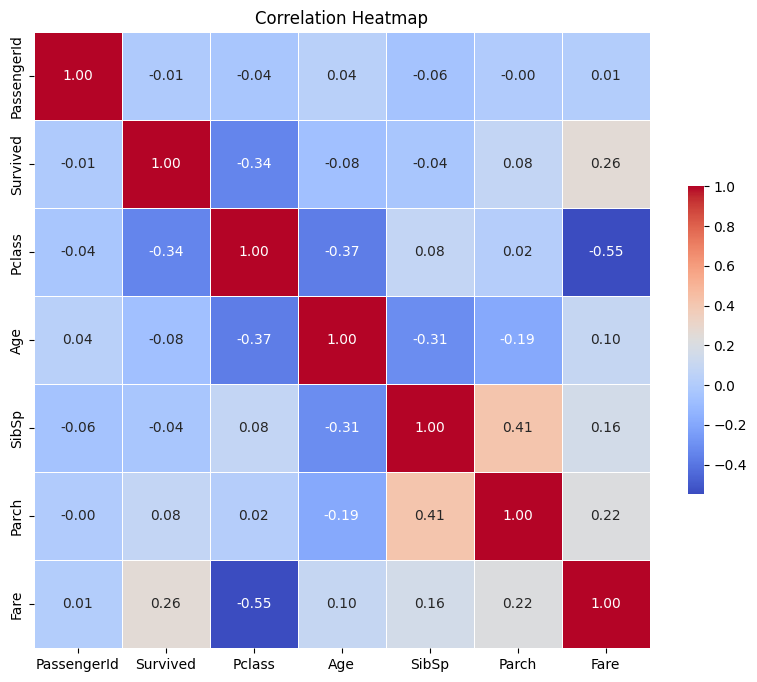


<<<<<<< Code >>>>>>

Invoking: `python_repl_ast` with `{'query': '# Using a valid colormap and setting the palette for seaborn\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr, cmap=\'coolwarm\', annot=True, fmt=\'.2f\', square=True, linewidths=.5, cbar_kws={"shrink": .5})\nplt.title(\'Correlation Heatmap\')\nplt.show()'}`




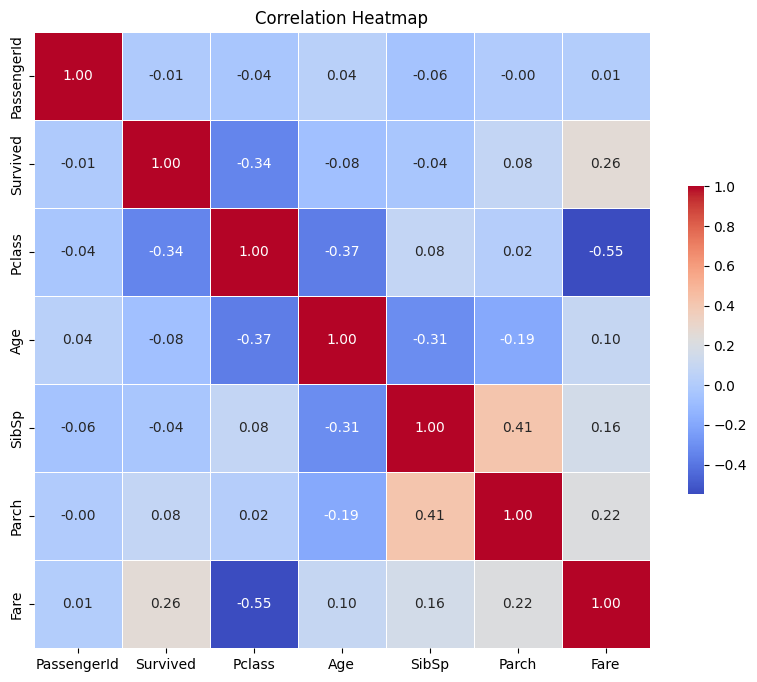

<<<<<<< Message >>>>>>

<<<<<<< Message >>>>>>
I have calculated the correlation matrix for the numeric columns in the DataFrame and visualized it using a heatmap. The heatmap displays the correlation coefficients between different features, with a color gradient representing the strength and direction of the correlations.

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
I have calculated the correlation matrix for the numeric columns in the DataFrame and visualized it using a heatmap. The heatmap displays the correlation coefficients between different features, with a color gradient representing the strength and direction of the correlations.
<<<<<<< 최종 답변 >>>>>>


In [24]:
# 질의에 대한 답변을 출력합니다.
response = agent.stream({"input": "corr() 을 구해서 히트맵 시각화"})

for step in response:
    stream_parser.process_agent_steps(step)

In [ ]:
# 질의에 대해 출력(정의한 함수에서 처리)
ask("남자와 여자의 생존율의 차이는 몇이야?")



> Entering new None chain...
<<<<<<< Code >>>>>>
# Calculate the survival rate for males and females
male_survival_rate = df[df['Sex'] == 'male']['Survived'].mean()
female_survival_rate = df[df['Sex'] == 'female']['Survived'].mean()

# Calculate the difference in survival rates
difference = female_survival_rate - male_survival_rate
difference
0.5531300709799203
<<<<<<< Code >>>>>>

Invoking: `python_repl_ast` with `{'query': "# Calculate the survival rate for males and females\nmale_survival_rate = df[df['Sex'] == 'male']['Survived'].mean()\nfemale_survival_rate = df[df['Sex'] == 'female']['Survived'].mean()\n\n# Calculate the difference in survival rates\ndifference = female_survival_rate - male_survival_rate\ndifference"}`


0.5531300709799203<<<<<<< Message >>>>>>
0.5531300709799203
<<<<<<< Message >>>>>>
남자와 여자의 생존율 차이는 약 0.553입니다. 이는 여자의 생존율이 남자보다 약 55.3% 더 높다는 것을 의미합니다.

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
남자와 여자의 생존율 차이는 약 0.553입니다. 이는 여자의 생존율이 남자보다 약 55.3% 더 높다는 것을 의미합니다.


## Toolkits 활용 Agent
Tookit은 다양한 도구를 지원하고 지원하는 도구를 실습

In [34]:
import os

# 폴더를 생성
if not os.path.exists("tmp"):
    os.mkdir("tmp")

In [35]:
# FileManagementToolkit을 가져옵니다. 이 도구는 파일 관리 작업을 수행하는 데 사용됩니다.
from langchain_community.agent_toolkits import FileManagementToolkit

# tmp폴더를 디렉토리로 설정
working_directory = "tmp"

# FileManagementToolkit 객체를 생성합니다.
# root_dir 디렉토리를 지정하여 모든 파일 작업이 이 디렉토리 내에서 작업하도록 한다
toolkit = FileManagementToolkit(root_dir=str(working_directory))

# get_tools메서드를 호출하여 사용 가능한 모든 파일 관리 도구를 가져옴
# 지원하는 도구로는 파일 복사, 삭제, 검색, 이동, 읽기, 쓰기, 디렉토리 목록 조회가 있다
available_tools = toolkit.get_tools()

# 사용 가능한 도구들의 이름을 출력
print("[사용 가능한 파일 관리 도구들]")
for tool in available_tools:
    print(f"- {tool.name}: {tool.description}")

[사용 가능한 파일 관리 도구들]
- copy_file: Create a copy of a file in a specified location
- file_delete: Delete a file
- file_search: Recursively search for files in a subdirectory that match the regex pattern
- move_file: Move or rename a file from one location to another
- read_file: Read file from disk
- write_file: Write file to disk
- list_directory: List files and directories in a specified folder


In [36]:
# 도구 중 일부만 지정하여 선택
tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "file_delete", "write_file", "list_directory"], # 파입 접근 권한을 설정
).get_tools()
tools

[ReadFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp')]

In [37]:
# selected_tools로 설정한 순서 대로 tool생성
read_tool, delete_tool, write_tool, list_tool = tools 

# 파일 쓰기 
# example.txt 파일에 Hello World!를 써서 저장
write_tool.invoke({"file_path": "example.txt", "text": "Hello World!"})

'File written successfully to example.txt.'

In [38]:
# 지정한 root디텍토리에 파일 목록 조회 
print(list_tool.invoke({}))

example.txt


In [39]:
# example.txt 파일 삭제
print(delete_tool.invoke({"file_path": "example.txt"}))

File deleted successfully: example.txt.


In [40]:
# 파일 목록 조회
# example.txt 파일 삭제된 것을 확인
print(list_tool.invoke({}))

No files found in directory .


In [41]:
# tool을 비롯한 필요한 모듈과 클래스를 임포트
from langchain.tools import tool
from typing import List, Dict
from langchain_teddynote.tools import GoogleNews


# 최신 뉴스 검색 도구를 정의
@tool
def latest_news(k: int = 5) -> List[Dict[str, str]]:
    """Look up latest news"""
    # GoogleNews 객체를 생성
    news_tool = GoogleNews()
    # 최신 뉴스를 검색하고 결과를 반환
    # k는 반환할 뉴스 항목의 수. 5개
    return news_tool.search_latest(k=k)


# 이미 등록 되어 있는 tool은 @tool을 안써도됨
# FileManagementToolkit을 사용하여 파일 관리 도구를 가져온다
tools = FileManagementToolkit(
    root_dir=str(working_directory),
).get_tools()

# 최신 뉴스 검색 도구를 tools 리스트에 추가
tools.append(latest_news)

# 모든 도구들이 포함된 tools 리스트를 출력
tools

[CopyFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 FileSearchTool(root_dir='tmp'),
 MoveFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp'),
 StructuredTool(name='latest_news', description='Look up latest news', args_schema=<class 'langchain_core.utils.pydantic.latest_news'>, func=<function latest_news at 0x000002E1E02F3E20>)]

In [42]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_teddynote.messages import AgentStreamParser

# session_id 를 저장할 딕셔너리 생성
store = {}

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공합니다. (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `latest_news` tool to find latest news. "
            "Make sure to use the `file_management` tool to manage files. ",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

# LLM 생성
llm = ChatOpenAI(model="gpt-4o-mini")

# Agent 생성
agent = create_tool_calling_agent(llm, tools, prompt)

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)


# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # session_id 가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 채팅 메시지 기록이 추가된 에이전트를 생성합니다.
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # 대화 session_id
    get_session_history,
    # 프롬프트의 질문이 입력되는 key: "input"
    input_messages_key="input",
    # 프롬프트의 메시지가 입력되는 key: "chat_history"
    history_messages_key="chat_history",
)

agent_stream_parser = AgentStreamParser()

In [43]:
# 뉴스검색, 파일 생성
# stream으로 실행 결과를 출력하고 대화내용을 기억
result = agent_with_chat_history.stream(
    { # 프롬프트 지정
        "input": "최신 뉴스 5개를 검색하고, 각 뉴스의 제목을 파일명으로 가지는 파일을 생성하고(.txt), "
        "파일의 내용은 뉴스의 내용과 url을 추가하세요. "
    },
    config={"configurable": {"session_id": "abc123"}}, # 채팅 session id를 지정
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:


> Entering new None chain...
[도구 호출]
Tool: latest_news
k: 5
Log: 
Invoking: `latest_news` with `{'k': 5}`




Invoking: `latest_news` with `{'k': 5}`


[{'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTE5uV0ctZHkzMjZ1dUJsa2Y4Ukt5RXBIYWZ6X21WM0RVdVVSclBoMlU5blVtVzVSdHFtQ3pXaEFCbjdCMVlIUGk5SzJUQXU2NlZzVWdJZXdKRzJqZ9IBX0FVX3lxTE4zQlhYdjlmOWxpeDFveXRZUy1MVHVzTXM1c2ZjakFKRFY5WFpUWGtDODZpQTJ6NWU2a2dpQlhYV0VFV0pqbGpJOERvTVQ2bzA0WXpwakpibmxLc29OT2lZ?oc=5', 'content': '왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은 - 경향신문'}, {'url': 'https://news.google.com/rss/articles/CBMidEFVX3lxTE9LUlYwV181R2s3RW1DNjhBTkFhYTM0TTk5Z2hLWWNud3kydXhTOXdHOWZYdlRFUmdBYlIzSFV5UE83cUpwOE9UQ2s2UzFFY0d2UVh4YzJROU5oa2ExMUZNdmVVZkk0TzBLb1V4andEUGFBQkxF?oc=5', 'content': '“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’ - 한겨레'}, {'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTE1GRlZONkhrRHdhb3FVM1pEQy03UEI5Qk9XU1VoWExjdzdmUk5BTkNUcmlwQ002MUVaVkxLZGo2QWZpSkpLQ3FFZFpXYk44cUdCQzhia2thY3Qyd9IBX0FVX3lxTE9xY0

In [44]:
# 파일 삭제, 뉴스검색, 파일복사
result = agent_with_chat_history.stream(
    {
        "input": "이전에 생성한 모든 파일을 `news` 폴더를 생성한 뒤 해당 폴더에 모든 파일을 복사하세요. "
        "내용도 동일하게 복사하세요. "
    },
    config={"configurable": {"session_id": "abc123"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)



Agent 실행 결과:


> Entering new None chain...
[도구 호출]
Tool: list_directory
Log: 
Invoking: `list_directory` with `{}`




Invoking: `list_directory` with `{}`


[기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt[관찰 내용]
Observation: [기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt
[도구 호출]
Tool: copy_file
source_path: 기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
destination_path: news/기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
Log: 
Invoking: `copy_file` with `{'source_path': "기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt", 'destination_path': "news/기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt"}`




Invoking: `copy_file` with `{'source_path': "기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt", 'destination_path': "news/기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt"}`


Error: [Errno 2] No such file or directory: "C:\\Users\\yujap\\github\\langchain-kr\\15-Agent\\tmp\\기자의 눈] '1약사 다

In [45]:
# 파일 지정해서 삭제
result = agent_with_chat_history.stream(
    {"input": "news 폴더를 제외한 모든 .txt 파일을 삭제하세요."},
    config={"configurable": {"session_id": "abc123"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:


> Entering new None chain...
[도구 호출]
Tool: file_search
pattern: *.txt
Log: 
Invoking: `file_search` with `{'pattern': '*.txt'}`




Invoking: `file_search` with `{'pattern': '*.txt'}`


[기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt
news\“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
news\기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
news\기초연금 25년 뒤 연120조 필요.txt
news\왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
news\친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt[관찰 내용]
Observation: [기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt
news\“이 대통령 지지” 63%…넷 중 한 명은 ‘뉴 이재명’.txt
news\기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
news\기초연금 25년 뒤 연120조 필요.txt
news\왜 조지아 현대차·LG엔솔 배터리 공장이었을까···미 이민단속국 ‘급습’ 배경은.txt
news\친트럼프 활동가 찰리 커크, 행사 도중 피습 사망.txt
[도구 호출]
Tool: file_delete
file_path: [기자의 눈] '1약사 다약국' 운영이 미칠 파장.txt
Log: 
Invoking: `f

### 실행결과
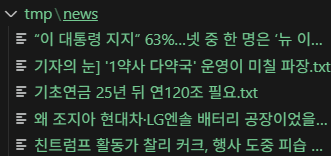